In [22]:
# =========================
# 1. LIBRARIES
# =========================
%pip install pandas numpy matplotlib seaborn scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import pandas as pd
# =========================
# 2. LOAD DVF 2024 (CORRECT PARSING)
# =========================
df = pd.read_csv(
    "valeursfoncieres-2024.txt",
    sep="\\|",
    engine="python"
)

print("Raw dataset:", df.shape)

Raw dataset: (3489149, 43)


In [24]:
# =========================
# 3. CHECK STRUCTURE
# =========================
print(df.columns)
print(df.shape)


Index(['Identifiant de document', 'Reference document', '1 Articles CGI',
       '2 Articles CGI', '3 Articles CGI', '4 Articles CGI', '5 Articles CGI',
       'No disposition', 'Date mutation', 'Nature mutation', 'Valeur fonciere',
       'No voie', 'B/T/Q', 'Type de voie', 'Code voie', 'Voie', 'Code postal',
       'Commune', 'Code departement', 'Code commune', 'Prefixe de section',
       'Section', 'No plan', 'No Volume', '1er lot',
       'Surface Carrez du 1er lot', '2eme lot', 'Surface Carrez du 2eme lot',
       '3eme lot', 'Surface Carrez du 3eme lot', '4eme lot',
       'Surface Carrez du 4eme lot', '5eme lot', 'Surface Carrez du 5eme lot',
       'Nombre de lots', 'Code type local', 'Type local', 'Identifiant local',
       'Surface reelle bati', 'Nombre pieces principales', 'Nature culture',
       'Nature culture speciale', 'Surface terrain'],
      dtype='str')
(3489149, 43)


In [25]:
# =========================
# 4. FILTER DIJON
# =========================
df = df[
    (df["Commune"].str.upper() == "DIJON") &
    (df["Type local"].isin(["Maison", "Appartement"]))
]

print("After Dijon filter:", df.shape)

After Dijon filter: (3170, 43)


In [26]:
#Only keeping the market transitions#

df = df[df["Nature mutation"] == "Vente"]

print("After keeping only Vente:", df.shape)

After keeping only Vente: (3054, 43)


In [27]:
# =========================
# 5. SELECT USEFUL COLUMNS
# =========================
df = df[
    [
        "Valeur fonciere",
        "Surface reelle bati",
        "Nombre pieces principales",
        "Type local",
        "Date mutation"
    ]
]

In [36]:
# =========================
# 6. DATA CLEANING
# =========================
df = df.dropna()

# Convert Valeur fonciere from string to numeric (replace comma with dot)
# Ensure the column is of string type before using .str accessor
df["Valeur fonciere"] = df["Valeur fonciere"].astype(str).str.replace(",", ".", regex=False).astype(float)

df = df[
    (df["Valeur fonciere"] > 20000) &
    (df["Valeur fonciere"] < 1_000_000) &
    (df["Surface reelle bati"] > 10) &
    (df["Surface reelle bati"] < 300)
]

print("After cleaning:", df.shape)


After cleaning: (2982, 8)


In [37]:
# =========================
# 7. FEATURE ENGINEERING
# =========================
df["is_house"] = df["Type local"].apply(
    lambda x: 1 if x == "Maison" else 0
)

df["Date mutation"] = pd.to_datetime(
    df["Date mutation"], dayfirst=True, errors="coerce"
)

df["log_price"] = np.log(df["Valeur fonciere"])

df["price_per_m2"] = df["Valeur fonciere"] / df["Surface reelle bati"]



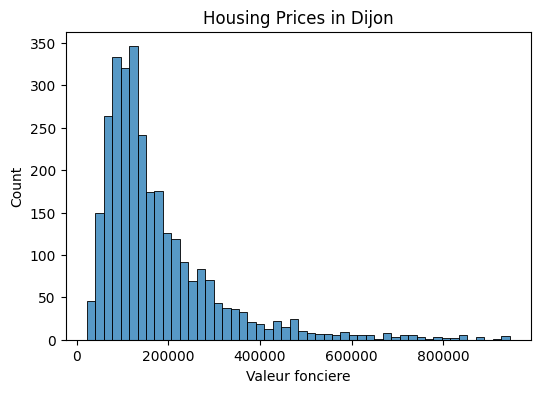

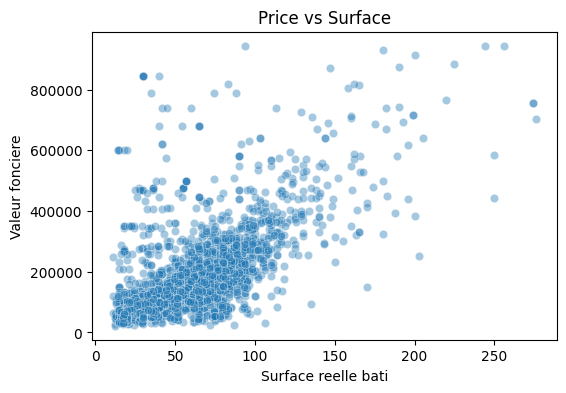

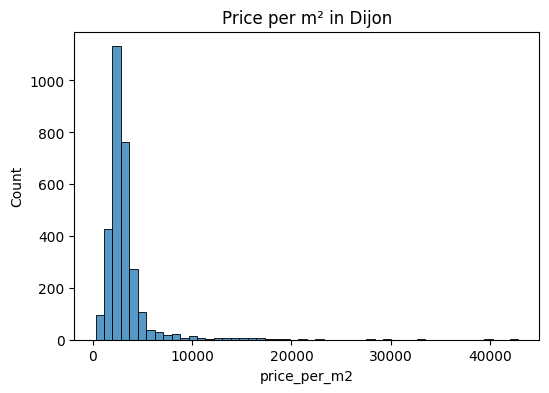

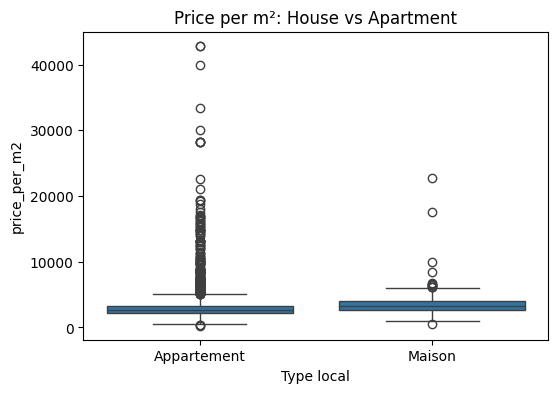

In [38]:
# =========================
# 8. EDA
# =========================
plt.figure(figsize=(6,4))
sns.histplot(df["Valeur fonciere"], bins=50)
plt.title("Housing Prices in Dijon")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(
    x="Surface reelle bati",
    y="Valeur fonciere",
    data=df,
    alpha=0.4
)
plt.title("Price vs Surface")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df["price_per_m2"], bins=50)
plt.title("Price per m² in Dijon")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(
    x="Type local",
    y="price_per_m2",
    data=df
)
plt.title("Price per m²: House vs Apartment")
plt.show()


In [41]:
# =========================
# 9. LOCATION FEATURE (POSTAL CODE)
# =========================
# Ensure the 'Code postal' column exists before proceeding
if "Code postal" in df.columns:
    df["Code postal"] = df["Code postal"].astype(str)

    df = pd.get_dummies(
        df,
        columns=["Code postal"],
        drop_first=True
    )
else:
    print("'Code postal' column not found in the DataFrame.")


'Code postal' column not found in the DataFrame.


In [42]:
# =========================
# 10. PREPARE DATA FOR ML
# =========================
X = df.drop(
    columns=[
        "Valeur fonciere",
        "log_price",
        "price_per_m2",
        "Type local",
        "Date mutation"
    ]
)

y = df["log_price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [43]:
# =========================
# 11. TRAIN / TEST SPLIT
# =========================
X = df[
    ["Surface reelle bati", "Nombre pieces principales", "is_house", "year"]
]
y = df["log_price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [44]:
# =========================
# 12. LINEAR REGRESSION (BASELINE)
# =========================
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression RMSE:", rmse_lr)
print("Linear Regression R²:", r2_lr)


Linear Regression RMSE: 0.4996182542887613
Linear Regression R²: 0.4303982554602682


In [45]:
# =========================
# 13. RANDOM FOREST (MAIN MODEL)
# =========================
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest RMSE:", rmse_rf)
print("Random Forest R²:", r2_rf)


Random Forest RMSE: 0.5060951766918623
Random Forest R²: 0.4155341882755027


Surface reelle bati          0.900189
Nombre pieces principales    0.056876
is_house                     0.042935
year                         0.000000
dtype: float64


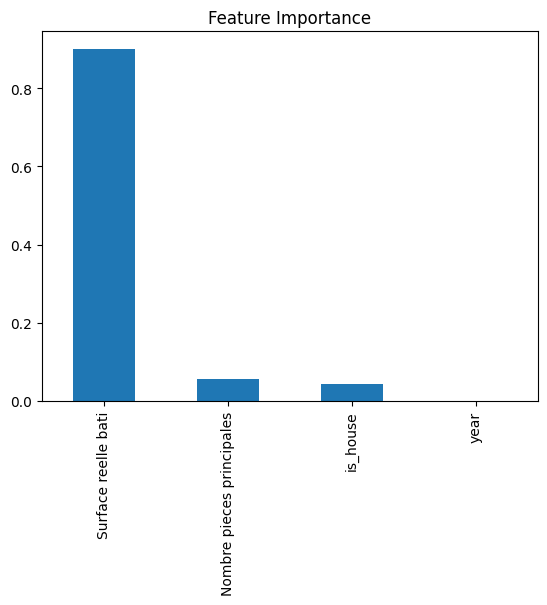

In [34]:
# =========================
# 12. FEATURE IMPORTANCE
# =========================
importances = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print(importances)

importances.plot(kind="bar", title="Feature Importance")
plt.show()


Surface reelle bati          0.899751
Nombre pieces principales    0.057078
is_house                     0.043171
year                         0.000000
dtype: float64


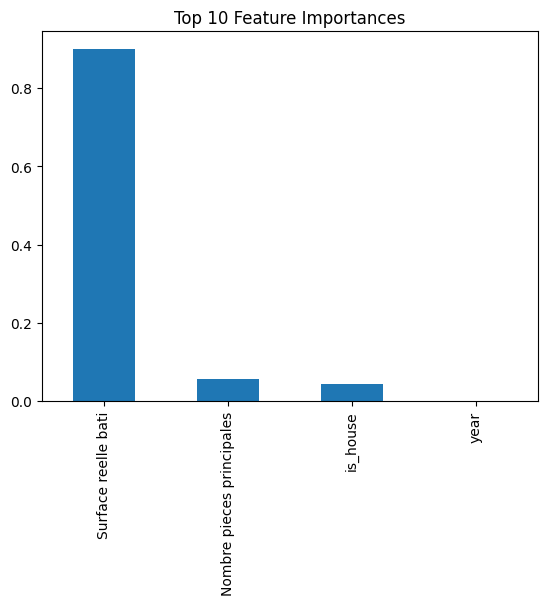

In [46]:
# =========================
# 14. FEATURE IMPORTANCE
# =========================
importances = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print(importances.head(10))

importances.head(10).plot(
    kind="bar",
    title="Top 10 Feature Importances"
)
plt.show()


In [47]:
# =========================
# 14. FINAL CHECK
# =========================
print("Final dataset shape:", df.shape)
df.head()


Final dataset shape: (2982, 9)


,Valeur fonciere,Surface reelle bati,Nombre pieces principales,Type local,Date mutation,is_house,year,log_price,price_per_m2
615337,105000.0,54.0,3.0,Appartement,2024-01-04,0,2024,11.561716,1944.444444
615352,131000.0,52.0,3.0,Appartement,2024-01-10,0,2024,11.782953,2519.230769
615365,69000.0,22.0,1.0,Appartement,2024-01-12,0,2024,11.141862,3136.363636
615374,297000.0,103.0,5.0,Appartement,2024-01-03,0,2024,12.601487,2883.495146
615380,73500.0,35.0,2.0,Appartement,2024-01-09,0,2024,11.205041,2100.000000
